In [1]:
import os
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import filtfilt, iirnotch, detrend, butter, cheby1, lfilter
import digital_processing as dp
import feature_extraction as fe

def bandpass_filter(input_signal, sr, lowcut, highcut, order=5):
    
    nyq = 0.5 * sr # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="band")
    output_signal = filtfilt(b, a, input_signal)
    
    return output_signal

def filter_signals(emg_stream):
    # Set variables
    l_bandpass = 10
    h_bandpass = 400
    sample_rate = int(emg_stream['info']['nominal_srate'][0])

    # Get signal information from the XDF file and apply filters
    l_ear_emg = emg_stream["time_series"][:, 0] - emg_stream["time_series"][:, 1] # Left ear EMG
    l_ear_emg = bandpass_filter(detrend(l_ear_emg), sample_rate, l_bandpass, h_bandpass)

    r_ear_emg = emg_stream["time_series"][:, 2] - emg_stream["time_series"][:, 3] # Right ear EMG
    r_ear_emg = bandpass_filter(detrend(r_ear_emg), sample_rate, l_bandpass, h_bandpass)

    return l_ear_emg, r_ear_emg

def plot_signal(signal, n_ear = ""):
    # Plot signals
    plt.figure(figsize=(10,3))

    plt.plot(signal)
    plt.title(f"{n_ear.capitalize()} Ear")

    plt.show()

def structure_data(emg_stream, EMGinfo_stream, ear_class, ear_emg, sample_rate, time_window=0.5):

    if emg_stream["time_stamps"][0] - EMGinfo_stream["time_stamps"][0] > 0: # This condition is true when EMG signal starts recording AFTER the classification, which makes no sense

        # Find the closest timestamp in the EMGinfo stream to the first timestamp in the EMG stream
        emg_first_timestamp = emg_stream["time_stamps"][0]
        emginfo_timestamps = EMGinfo_stream["time_stamps"]

        closest_index = np.abs(emginfo_timestamps - emg_first_timestamp).argmin()
        print(f"EMG stream starts after classification stream. Closest index: {closest_index}")
    else:
        closest_index = 0
        print(f"EMG stream starts at the same time as the classification stream. Closest index: {closest_index}")
    
    
    # This code will extract a window of EMG data before each class label in the EMGinfo stream and store it in a DataFrame
    # Corresponding number of samples based on frequency and the time window
    samples_window = int(sample_rate * time_window)

    # Create an empty DataFrame
    columns = ['class_label'] + ["stream_idx"] + [f'emg_{i}' for i in range(samples_window)]
    df = pd.DataFrame(columns=columns)

    for class_time, class_label in zip(EMGinfo_stream['time_stamps'][closest_index:], ear_class):
        # Find the closest timestamp in the EMG stream
        idx = np.abs(emg_stream['time_stamps'] - class_time).argmin()
        
        # Check if we can extract a full window of data without going out of bounds
        if idx >= samples_window:
            # Extract EMG data for the window
            emg_data_window = ear_emg[idx - samples_window:idx]
            
            # Append to the DataFrame
            row_data = [class_label] + [idx] + emg_data_window.tolist()
            df.loc[len(df)] = row_data
    
    return df

def get_features(ear_df, sample_rate, time_window=0.5, name=""):

    frame = int(time_window*sample_rate) # Number of samples in the time window

    ear_df_values = ear_df.iloc[:, 2:].values # Get the values of the EMG data from the 2nd column onwards

    output_df = pd.DataFrame()  # Create an empty dataframe to store the outputs

    for row in ear_df_values:
        features_df, _ = fe.features_estimation(row, name, sample_rate, frame, 1, plot=False, verbose=False)  # Call the features_estimation function
        output_df = pd.concat([output_df, features_df], axis=1)  # Concatenate the features dataframe to the output dataframe column by column

    return pd.concat([ear_df.reset_index(drop=True), output_df.T.reset_index(drop=True)], axis=1) # Concatenate the output dataframe with the original dataframe

def filter_signals_2(emg_stream):

    # Set variables
    l_bandpass = 10
    h_bandpass = 400
    sample_rate = int(emg_stream['info']['nominal_srate'][0])

    l_ear_emg = emg_stream["time_series"][:, 0] - emg_stream["time_series"][:, 1] # Left ear EMG
    r_ear_emg = emg_stream["time_series"][:, 2] - emg_stream["time_series"][:, 3] # Right ear EM

    # Filter the 50Hz armonics (50, 100, 150, 200 Hz)
    for i in range(50, 250, 50):
        l_ear_notch = dp.notch_filter(l_ear_emg, sample_rate, i, False)
        r_ear_notch = dp.notch_filter(r_ear_emg, sample_rate, i, False)

    # Apply bandpass filters 
    l_ear_bandpass = dp.bp_filter(l_ear_notch, l_bandpass, h_bandpass, sample_rate, False)
    r_ear_bandpass = dp.bp_filter(r_ear_notch, l_bandpass, h_bandpass, sample_rate, False)

    # Apply wavelet denoising
    l_ear_denoise = dp.denoisewavelet(l_ear_bandpass)
    r_ear_denoise = dp.denoisewavelet(r_ear_bandpass)

    return l_ear_denoise, r_ear_denoise

def process_xdf(path):
    
    folders = path.split("/")[:-1]
    folder = "/".join(folders)
    
    csv_file_l = folder + '/l_ear_features_' + folders[-1] + '.csv'
    csv_file_r = folder + '/r_ear_features_' + folders[-1] + '.csv'

    print(f"Data in folder {folder} is being processed.")

    print("Checking if csv files exist.")
    if os.path.exists(csv_file_l) and os.path.exists(csv_file_r):
        print("Files exist. Loading csv files.")
        l_ear_features_df = pd.read_csv(csv_file_l)
        r_ear_features_df = pd.read_csv(csv_file_r)
    
    else:
        print("Files do not exist. Creating csv files.")
        data, _ = pyxdf.load_xdf(path)

        EMGinfo_stream = [stream for stream in data if stream["info"]["name"][0] == "EMGinfo"][0]
        emg_stream = [stream for stream in data if "eegoSports " in stream["info"]["name"][0]][0]

        sample_rate = int(emg_stream['info']['nominal_srate'][0])
        time_window = 0.5

        l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
        l_ear_class = EMGinfo_stream["time_series"][:, 6]
        r_ear_class = EMGinfo_stream["time_series"][:, 7]

        l_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=l_ear_class, ear_emg=l_ear_emg, sample_rate=sample_rate)
        r_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=r_ear_class, ear_emg=r_ear_emg, sample_rate=sample_rate)

        l_ear_features_df = get_features(l_ear_df, sample_rate, time_window, "left")
        r_ear_features_df = get_features(r_ear_df, sample_rate, time_window, "right")
        l_ear_features_df.to_csv(folder + '/l_ear_features_' + folders[-1] + '.csv', index=False)
        r_ear_features_df.to_csv(folder + '/r_ear_features_' + folders[-1] + '.csv', index=False)

    return l_ear_features_df, r_ear_features_df



In [3]:
for i in range(4, 10):
    if i == 5:
        continue
    path = "Data/AM001/s" + str(i) + "/sub-AM001_s" + str(i) + "_task6.xdf"
    print(f"Processing {path}")
    process_xdf(path)


Processing Data/AM001/s4/sub-AM001_s4_task6.xdf
Data in folder Data/AM001/s4 is being processed.
Checking if csv files exist.
Files exist. Loading csv files.
Processing Data/AM001/s6/sub-AM001_s6_task6.xdf
Data in folder Data/AM001/s6 is being processed.
Checking if csv files exist.
Files exist. Loading csv files.
Processing Data/AM001/s7/sub-AM001_s7_task6.xdf
Data in folder Data/AM001/s7 is being processed.
Checking if csv files exist.
Files exist. Loading csv files.
Processing Data/AM001/s8/sub-AM001_s8_task6.xdf
Data in folder Data/AM001/s8 is being processed.
Checking if csv files exist.
Files exist. Loading csv files.
Processing Data/AM001/s9/sub-AM001_s9_task6.xdf
Data in folder Data/AM001/s9 is being processed.
Checking if csv files exist.
Files exist. Loading csv files.


In [5]:
a, b = process_xdf("Data/AM001/s2/sub-AM001_s2_task6.xdf")

Data in folder Data/AM001/s2 is being processed.
Checking if csv files exist.
Files exist. Loading csv files.


Stream 6: Calculated effective sampling rate 6.6649 Hz is different from specified rate 20.0000 Hz.
Stream 12: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.
Stream 8: Calculated effective sampling rate 0.0000 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 6.7235 Hz is different from specified rate 500.0000 Hz.
c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\pyyawt\dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


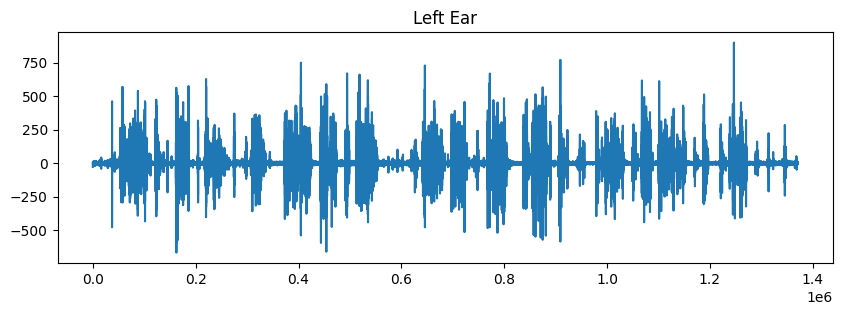

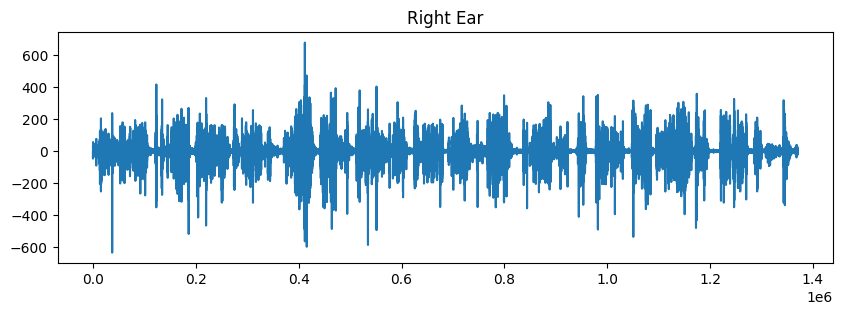

In [6]:
data, header = pyxdf.load_xdf("Data/AM001/s2/sub-AM001_s2_task6.xdf")

EMGinfo_stream = [stream for stream in data if stream["info"]["name"][0] == "EMGinfo"][0]
emg_stream = [stream for stream in data if "eegoSports " in stream["info"]["name"][0]][0]

sample_rate = int(emg_stream['info']['nominal_srate'][0])

l_ear_emg, r_ear_emg = filter_signals_2(emg_stream)
l_ear_class = EMGinfo_stream["time_series"][:, 6]
r_ear_class = EMGinfo_stream["time_series"][:, 7]
plot_signal(l_ear_emg, "left")
plot_signal(r_ear_emg, "right")

Comparison with the filters I made:


<img src="./images/My_filter_comparison.png" width="640" height="360" />

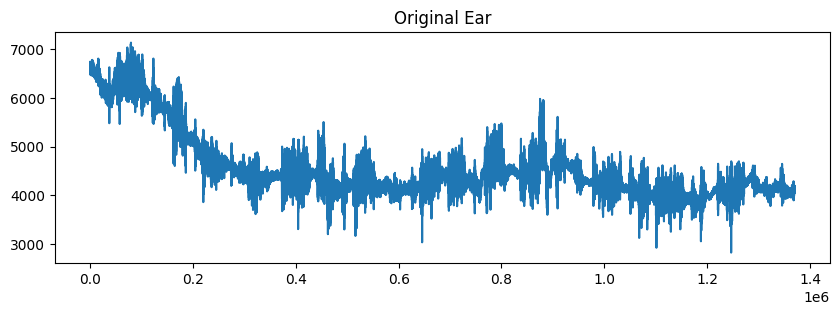

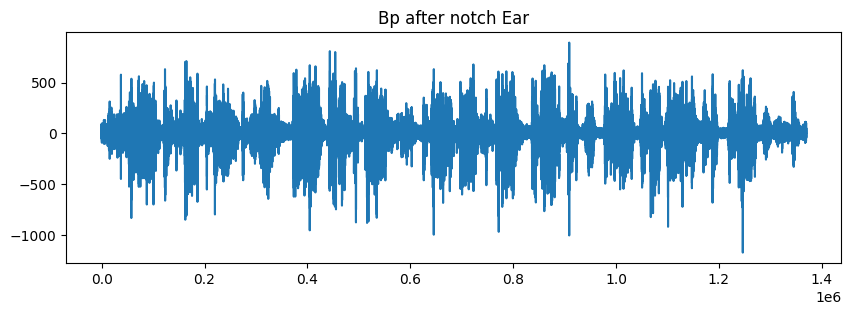

c:\Users\quiqu\anaconda3\envs\antneuro2\lib\site-packages\pyyawt\dwt.py:471: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif (np.any(mode == modes)):


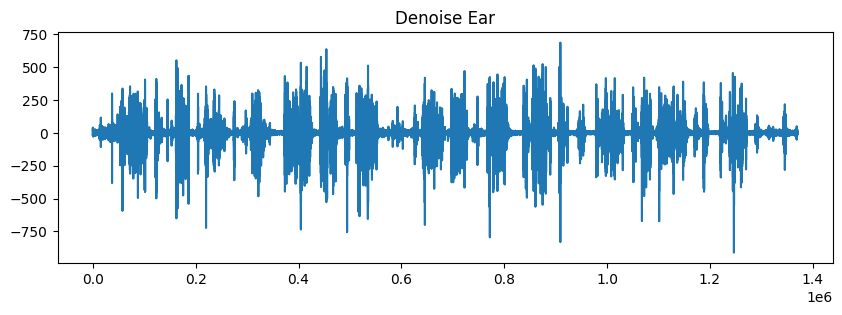

In [7]:
# Signal processing (testing to see if the functions work as expected)

test_signal = emg_stream["time_series"][:, 1] - emg_stream["time_series"][:, 2] # Right ear EMG
plot_signal(test_signal, "original")

test_notch = dp.notch_filter(test_signal, sample_rate, 50, False)
test_notch = dp.notch_filter(test_signal, sample_rate, 100, False)
test_notch = dp.notch_filter(test_signal, sample_rate, 150, False)
test_notch = dp.notch_filter(test_signal, sample_rate, 200, False)
# plot_signal(test_notch, "notch on 50Hz armonics")

test_bandpass = dp.bp_filter(test_signal, 10, 400, sample_rate, False)
# plot_signal(test_bandpass, "bp on original")

test_bp_notch = dp.bp_filter(test_notch, 10, 400, sample_rate, False)
plot_signal(test_bp_notch, "bp after notch")

test_denoise = dp.denoisewavelet(test_bandpass)
plot_signal(test_denoise, "denoise")


In [ ]:
# Create DataFrames with a 500ms window of EMG data before each class label

# l_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=l_ear_class, ear_emg=l_ear_emg, sample_rate=sample_rate)
# display(l_ear_df)
# l_ear_df.to_csv('l_ear_df.csv', index=False)

# r_ear_df = structure_data(emg_stream, EMGinfo_stream, ear_class=r_ear_class, ear_emg=r_ear_emg, sample_rate=sample_rate)
# display(r_ear_df)
# r_ear_df.to_csv('r_ear_df.csv', index=False)

: 

In [ ]:
# Load the DataFrames and display the first rows
l_ear_df = pd.read_csv('l_ear_df.csv')
r_ear_df = pd.read_csv('r_ear_df.csv')
# display(l_ear_df)
# display(r_ear_df)

# l_ear_features_df = get_features(l_ear_df, sample_rate, 0.5, "left")
# r_ear_features_df = get_features(r_ear_df, sample_rate, 0.5, "right")
# l_ear_features_df.to_csv('l_ear_features_df.csv', index=False)
# r_ear_features_df.to_csv('r_ear_features_df.csv', index=False)


: 

In [ ]:
l_ear_features_df = pd.read_csv('l_ear_features_df.csv')
r_ear_features_df = pd.read_csv('r_ear_features_df.csv')

display(l_ear_features_df)
display(r_ear_features_df)

: 

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import svm

for i in range(2, 10):
    if i == 5:
        continue
    path = "Data/s" + str(i) + "/sub-AM001_s" + str(i) + "_task6.xdf"
    print(f"Processing {path}")

    l_ear_features_df, r_ear_features_df = process_xdf(path)

    X = l_ear_features_df.iloc[:, 1002:]
    y = l_ear_features_df['class_label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    lda_score = cross_val_score(lda, X_test, y_test, cv=50, scoring="accuracy")
    print("Precision with LDA: %0.2f (+/- %0.2f)" % (lda_score.mean(), lda_score.std() * 2))

    svm_clf = svm.SVC(decision_function_shape="ovo") # One vs One
    svm_clf.fit(X_train, y_train)
    svm_score = cross_val_score(svm_clf, X_test, y_test, cv=50, scoring="accuracy")
    print("Precision with SVM (One vs one): %0.2f (+/- %0.2f)" % (svm_score.mean(), svm_score.std() * 2))

    svm_clf = svm.SVC(decision_function_shape="ovr") # One vs Rest
    svm_clf.fit(X_train, y_train)
    svm_score = cross_val_score(svm_clf, X_test, y_test, cv=50, scoring="accuracy")
    print("Precision with SVM (One vs rest): %0.2f (+/- %0.2f)" % (svm_score.mean(), svm_score.std() * 2))
    print("\n")



: 

In [ ]:
# from sklearn.feature_selection import RFECV
# from sklearn.svm import SVR


# l_ear_features_df, r_ear_features_df = process_xdf("Data/s2/sub-AM001_s2_task6.xdf")
# X = l_ear_features_df.iloc[:, 2:]
# y = l_ear_features_df['class_label'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# estimator = svm.SVC(decision_function_shape="ovr", kernel="linear")
# selector = RFECV(estimator, step=1, cv=5)
# selector = selector.fit(X_train, y_train)
# selector.support_
# selector.ranking_

: 